# Plotting and filtering Lagrangian and Euleian data
## First, I load the Eulerian fields

In [3]:
#May need this for area weighting 
area=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/RAC.data', dtype='>f4')
area = area.reshape(2160,2160)

In [9]:
#I need to load the same time period in the Eulerian and Lagrangian data. The Eulerian data starts earlier. The following calculation find how much earlier
30096/144 #timestep 0 is this step

209.0

In [10]:

337/2 #168 timesteps before timestep 0 

168.5

In [11]:
209-168 # this is the first timestep covered by the Lagrangian run

41

In [13]:
209+168 # this is the last timestep covered by the Lagrangian run

377

In [3]:
import xarray as xr
import numpy as np
import xrft
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
from xhistogram.xarray import histogram
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [4]:
uvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel.zarr')
vvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel.zarr')

uvel_merged = uvel_merged.isel(time=slice(41,378)).isel(k=0)

vvel_merged = vvel_merged.isel(time=slice(41,378)).isel(k=0)

uvel_merged['time'] = uvel_merged['time']/ np.timedelta64(1, 's')
vvel_merged['time'] = vvel_merged['time']/ np.timedelta64(1, 's')
grid = Grid(uvel_merged, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [68]:
dt=168

In [69]:
#calculate power spectrum in Eulerian space
with ProgressBar():
    uhat2 = xrft.power_spectrum(grid.interp(uvel_merged.U,'X').chunk({'time':-1}).isel(time=slice(168-dt,169+dt)),dim='time', detrend='linear', window=True).compute()
    vhat2 = xrft.power_spectrum(grid.interp(vvel_merged.V,'Y',boundary='fill').chunk({'time':-1}).isel(time=slice(168-dt,169+dt)),dim='time', detrend='linear', window=True).compute()
ekehat_eul = .5*(uhat2 + vhat2)


[########################################] | 100% Completed | 43.1s
[########################################] | 100% Completed | 40.6s


## Then, I load the lagrangian fields

In [70]:
ds = xr.open_zarr('/swot/SUM01/spencer/run_1week_orechunked.zarr')

In [71]:
ds = ds.isel(niter=slice(1,338))
#ds = ds.drop_sel(niter=-20000)
ds = ds.isel(z0=3)
ds['time'] = ds['niter']*3600/144
ds = ds.assign_coords({"time": ds.time})
ds = ds.swap_dims({"niter": "time"})
ds = ds.where(ds.u!=-999)
#ds = ds.dropna('npart')
#ds.niter.min()

In [72]:
mask_roundx = abs(ds.x.diff('time')).max('time')
mask_roundy = abs(ds.y.diff('time')).max('time')
ds = ds.where(mask_roundx<30)
ds = ds.where(mask_roundy<30)
#ds = ds.dropna('npart')
mask = ds['u'].where(np.isfinite(ds['u']),0).all('time')
ds=ds.where(mask>0,0)

In [73]:
#Calculate power spectrum in Lagrangian space
with ProgressBar():
    uhat2 = xrft.power_spectrum(ds.u.drop('niter').isel(time=slice(168-dt,169+dt)),dim='time', detrend='linear', window=True).compute()
    vhat2 = xrft.power_spectrum(ds.v.drop('niter').isel(time=slice(168-dt,169+dt)),dim='time', detrend='linear', window=True).compute()
ekehat = .5*(uhat2 + vhat2)

[#                                       ] | 4% Completed |  2.8s

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  1min  5.5s
[#                                       ] | 3% Completed |  1.7s

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  1min 16.5s


In [74]:
mask_Eul = mask.rename({'x0':'i','y0':'j'})
mask_Eul = mask_Eul.assign_coords({'i':vvel_merged.V.i,'j':uvel_merged.U.j})

In [75]:
spec0 = int((ekehat['freq_time'].size-1)/2)

In [76]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


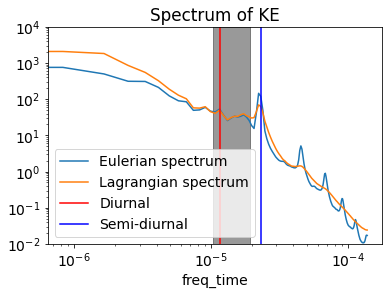

In [77]:
#Plot Lagrangian and Eulerian power spectrum
f1 = 2*2*np.pi/24/3600*np.sin(-57*np.pi/180)
f2 = 2*2*np.pi/24/3600*np.sin(-26.6*np.pi/180)
ekehat_eul.where(mask_Eul>0).mean(['i','j'])[spec0:].plot(label="Eulerian spectrum")
(ekehat.where(mask>0)).mean(['x0','y0'])[spec0:].plot(label='Lagrangian spectrum')

plt.axvline([1/86400],label='Diurnal',color='r')
plt.axvline([2/86400],label='Semi-diurnal',color='b')
#plt.axvline([-f1/2/np.pi],label='Inertial 1',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
bottom, height = 0, 10**8
ax = plt.gca()
p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Spectrum of KE')
plt.ylim(10**-2,10**4)

fig=plt.gcf()
fig.savefig('agulhas_spectrum_lagrang_surf.png')

# Plot rotary spectrum in order to characterize near-inertial motions

In [206]:
z=ds.u.drop('niter')+1j*ds.v.drop('niter')
with ProgressBar():
    z2 = xrft.power_spectrum(z,dim='time', detrend='linear', window=True).compute()

[########################################] | 100% Completed |  2min 44.4s


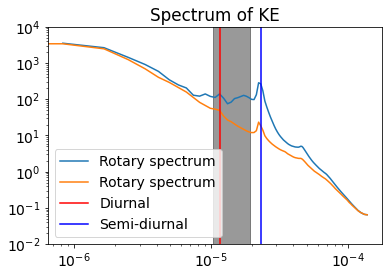

In [207]:
plt.plot(z2.freq_time[spec0:],z2.mean(['npart'])[spec0:],label='Rotary spectrum')
plt.plot(-z2.freq_time[spec0::-1],z2.mean(['npart'])[spec0::-1],label='Rotary spectrum')
plt.axvline([1/86400],label='Diurnal',color='r')
plt.axvline([2/86400],label='Semi-diurnal',color='b')
#plt.axvline([-f1/2/np.pi],label='Inertial 1',color='k')
#plt.axvline([-f2/2/np.pi],label='Inertial 2',color='k')
left, width = -f1/2/np.pi, -f2/2/np.pi+f1/2/np.pi
bottom, height = 0, 10**8
ax = plt.gca()
p = plt.Rectangle((left, bottom), width, height, fill=True,color='k',alpha=0.4)
ax.add_patch(p)

plt.legend()
plt.xscale('log')
plt.yscale('log')
plt.title('Spectrum of KE')
plt.ylim(10**-2,10**4)

fig=plt.gcf()
fig.savefig('rotary_spectrum.pdf')

In [142]:
ds.y.max().values

array(-48.33070352)

# Calculate energy as a function of space

In [79]:
#define frequency spacing and integrate
dfreq = ekehat.freq_time[spec0:].diff('freq_time')[1]
EKE_lag = (ekehat[spec0:,:,:]*dfreq).sum('freq_time')
EKE_eul = (ekehat_eul[spec0:,:,:]*dfreq).sum('freq_time')

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


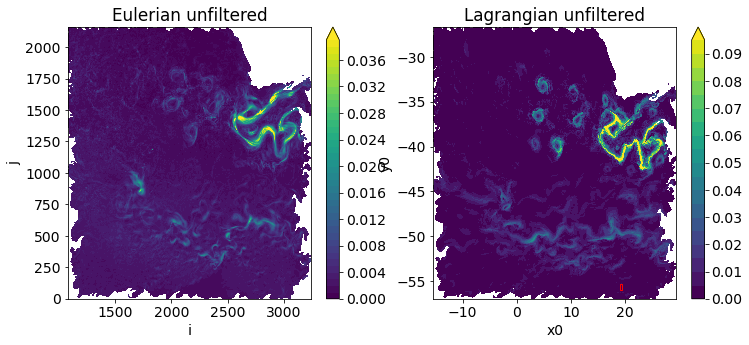

In [82]:
plt.figure(figsize=(12,5))
import matplotlib.patches as patches
plt.subplot(121)
EKE_eul.where(mask_Eul>0).plot.pcolormesh(levels=np.arange(0,0.04,0.001),rasterized=True)
plt.title('Eulerian unfiltered')
plt.subplot(122)
EKE_lag.where(mask>0).plot.pcolormesh(x="x0",y="y0",levels=np.arange(0,0.1,0.005),rasterized=True)


# Create a Rectangle patch
rect = patches.Rectangle((19.1,-56),0.35,0.6,linewidth=1,edgecolor='r',facecolor='none')

# Add the patch to the Axes
ax=plt.gca()
ax.add_patch(rect)
plt.title('Lagrangian unfiltered')
fig=plt.gcf()
fig.savefig('KE_unfiltered.png')

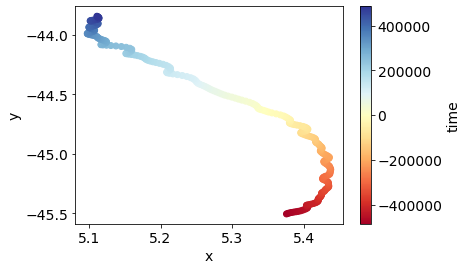

In [173]:
#ds.sel(time=0).isel(npart=slice(300010-10000,300010+10000)).plot.scatter(x='x0',y='y0',hue='z0',cmap='Greys',add_guide=False)
dt1=135
ds.isel(x0=1000).isel(y0=1000).isel(time=slice(168-dt1,169+dt1)).plot.scatter(x='x',y='y',hue='time',cmap='RdYlBu')
#plt.xlim(19.1,19.45)
#plt.ylim(-56,-55.6)
fig=plt.gcf()
fig.savefig('particle_path.png')

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


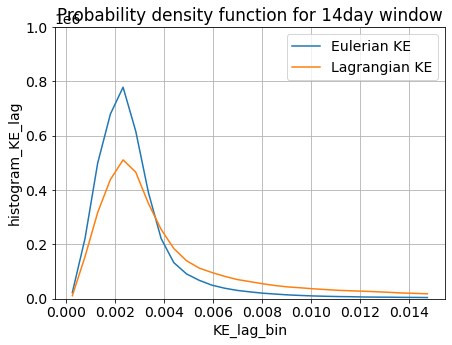

In [85]:
plt.figure(figsize=(7,5))
bins = np.linspace(0, 0.015, 30)


h = histogram(EKE_eul.rename('KE_eul').where(mask_Eul>0), bins=[bins])
h.plot(label='Eulerian KE')

plt.ylim(0,1*10**6)

h = histogram(EKE_lag.rename('KE_lag').where(mask>0), bins=[bins])
h.plot(label='Lagrangian KE')
plt.ylim(0,1*10**6)
plt.grid()
plt.legend()
plt.title('Probability density function for 14day window')

fig=plt.gcf()
fig.savefig('eulerian_KE_pdf_surf.png')

## Now let's do a filter at a single frequency of 0.9* the minimum f

In [250]:
max_freq = (-f2/2/np.pi)*0.9
max_freq

9.32831432997437e-06

In [251]:
#np.argmax()#[180]#.sel(ekehat.freq_time<max_freq)
spec_cut = (ekehat.freq_time[spec0:]<max_freq).argmin().values+spec0

In [252]:
EKE_eul_filtered = (ekehat_eul[spec0:spec_cut,:,:]*dfreq).sum('freq_time')

In [253]:
EKE_lag_filtered = (ekehat[spec0:spec_cut,:]*dfreq).sum('freq_time')
EKE_lagf_pd = EKE_lag_filtered.rename('EKE_lag').to_dataframe().drop(columns="freq_time_spacing")
df_filtered = pd.DataFrame(EKE_lagf_pd.EKE_lag.values, index=index)

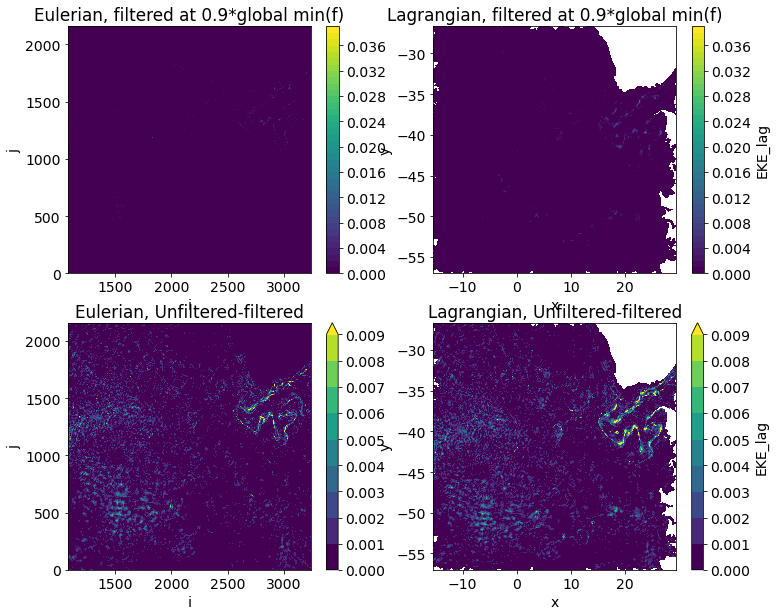

In [254]:
plt.figure(figsize=(12,10))
plt.subplot(221)
EKE_eul_filtered.plot.pcolormesh(levels=np.arange(0,0.04,0.001),rasterized=True)
plt.title('Eulerian, filtered at 0.9*global min(f)')
plt.subplot(222)
EKE_lag_reshaped_filered = df_filtered.rename(columns={0: "EKE_lag"}).to_xarray()
EKE_lag_reshaped_filered.EKE_lag.plot.pcolormesh(x="x",y="y",levels=np.arange(0,0.04,0.001),rasterized=True)
plt.title('Lagrangian, filtered at 0.9*global min(f)')
plt.subplot(223)
(EKE_eul-EKE_eul_filtered).plot.pcolormesh(levels=np.arange(0,0.01,0.001),rasterized=True)
plt.title('Eulerian, Unfiltered-filtered')
plt.subplot(224)
(EKE_lag_reshaped.EKE_lag-EKE_lag_reshaped_filered.EKE_lag
).plot.pcolormesh(x="x",y="y",levels=np.arange(0,0.01,0.001),rasterized=True)
plt.title('Lagrangian, Unfiltered-filtered')
fig=plt.gcf()
fig.savefig('KE_filtered.pdf')

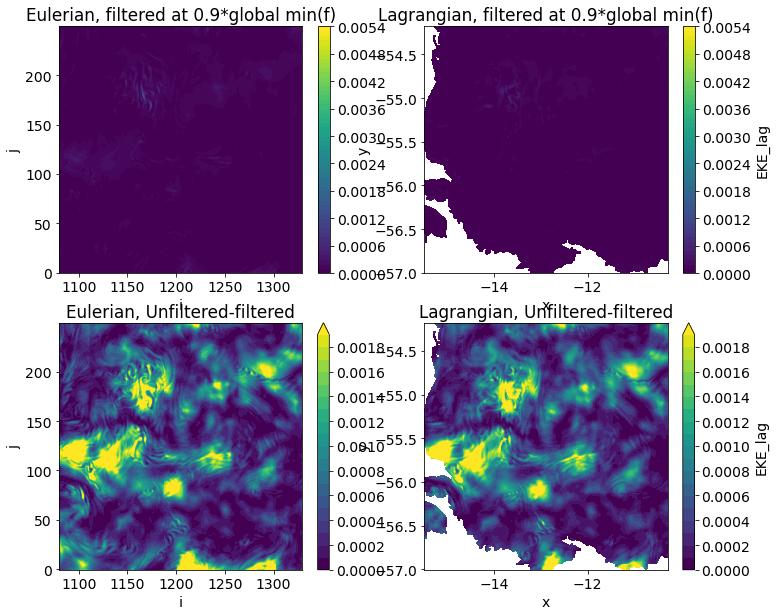

In [255]:
plt.figure(figsize=(12,10))
plt.subplot(221)
EKE_eul_filtered[0:250,0:250].plot.pcolormesh(levels=np.arange(0,0.0055,0.0001),rasterized=True)
plt.title('Eulerian, filtered at 0.9*global min(f)')
plt.subplot(222)
EKE_lag_reshaped_filered.EKE_lag[0:250,0:250].plot.pcolormesh(x="x",y="y",levels=np.arange(0,0.0055,0.0001),rasterized=True)
plt.title('Lagrangian, filtered at 0.9*global min(f)')
plt.subplot(223)
(EKE_eul-EKE_eul_filtered)[0:250,0:250].plot.pcolormesh(levels=np.arange(0,0.002,0.0001),rasterized=True)
plt.title('Eulerian, Unfiltered-filtered')
plt.subplot(224)
(EKE_lag_reshaped.EKE_lag-EKE_lag_reshaped_filered.EKE_lag
)[0:250,0:250].plot.pcolormesh(x="x",y="y",levels=np.arange(0,0.002,0.0001),rasterized=True)
plt.title('Lagrangian, Unfiltered-filtered')
fig=plt.gcf()
fig.savefig('KE_zoom.pdf')

In [256]:
mask_Eul = EKE_lag_reshaped.EKE_lag.where(np.isnan(EKE_lag_reshaped.EKE_lag),1)
mask_Eul = mask_Eul.where(mask_Eul==1,0).values
mask_Eul

array([[0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       [0., 0., 0., ..., 1., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Now let's do a filter at 0.9* the minimum f each trajectory (lagrangian only)

In [236]:
ekehat_labeled = ekehat.assign_coords({"min_lat":ds.y.min('time')})
f_local = 2*2*np.pi/24/3600*np.sin(ekehat_labeled.min_lat*np.pi/180)
maxfreq_local = (-f_local/2/np.pi)*0.9

In [237]:
spec_cut = (ekehat.freq_time[spec0:]<maxfreq_local).argmin('freq_time').values+spec0

In [238]:
EKE_lag_locfiltered = (ekehat[spec0:,:].where(ekehat.freq_time[spec0:]<maxfreq_local)*dfreq).sum('freq_time')
EKE_lagfloc_pd = EKE_lag_locfiltered.rename('EKE_lag').to_dataframe().drop(columns="freq_time_spacing")
df_locfiltered = pd.DataFrame(EKE_lagfloc_pd.EKE_lag.values, index=index)

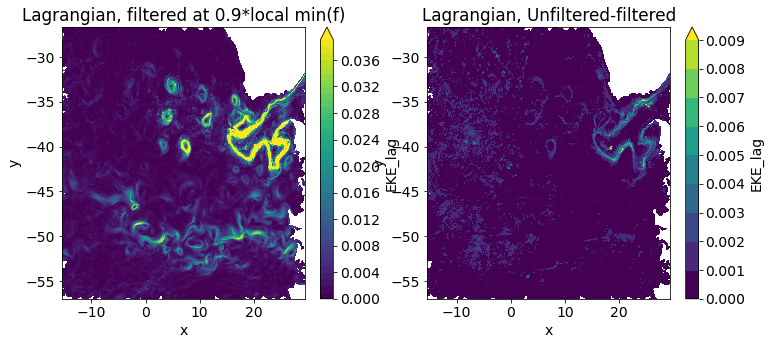

In [239]:
plt.figure(figsize=(12,5))
plt.subplot(121)
EKE_lag_reshaped_locfilered = df_locfiltered.rename(columns={0: "EKE_lag"}).to_xarray()
EKE_lag_reshaped_locfilered.EKE_lag.plot.pcolormesh(x="x",y="y",levels=np.arange(0,0.04,0.001),rasterized=True)
plt.title('Lagrangian, filtered at 0.9*local min(f)')
plt.subplot(122)
(EKE_lag_reshaped.EKE_lag-EKE_lag_reshaped_filered.EKE_lag
).plot.pcolormesh(x="x",y="y",levels=np.arange(0,0.01,0.001),rasterized=True)
plt.title('Lagrangian, Unfiltered-filtered')
fig=plt.gcf()
fig.savefig('KE_filtered_local.pdf')

In [240]:
EKE_eul.max().values

array(0.0638229)

In [257]:
EKE_eul_mask = xr.Dataset(
    data_vars=dict(
        EKE_eul=(["i", "j"], EKE_eul.T),
        mask=(["i", "j"], mask_Eul),
    ),
    coords=dict(
        i=(["i"], EKE_eul.i),
        j=(["j"], EKE_eul.j)
    ))

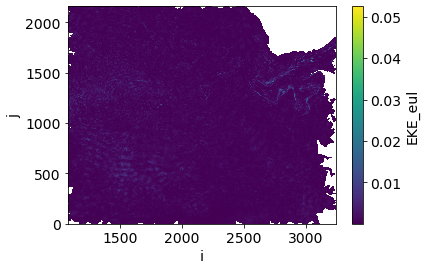

In [179]:
EKE_eul_mask.EKE_eul.where(EKE_eul_mask.mask==1).plot(x='i')

Text(0.5, 1.0, 'Probability density function for 14day window')

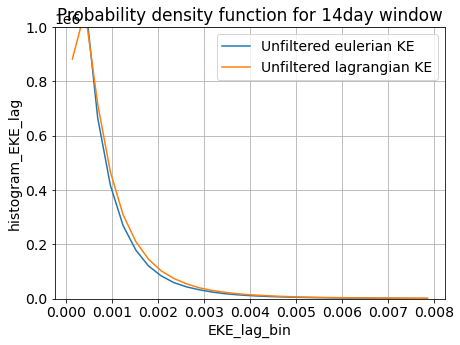

In [258]:
plt.figure(figsize=(7,5))
bins = np.linspace(0, 0.008, 30)


h = histogram(EKE_eul_mask.EKE_eul.where(EKE_eul_mask.mask==1), bins=[bins])
h.plot(label='Unfiltered eulerian KE')
plt.ylim(0,10**6)

h = histogram(EKE_lag_reshaped.EKE_lag, bins=[bins])
h.plot(label='Unfiltered lagrangian KE')
plt.ylim(0,10**6)
plt.grid()
plt.legend()
plt.title('Probability density function for 14day window')


#fig=plt.gcf()
#fig.savefig('eulerian_KE_pdf_14day.png')

In [259]:
#mean Eulerian energy
((EKE_eul_mask.EKE_eul.where(EKE_eul_mask.mask==1)*area).sum(['i','j'])/np.sum(area)).values



array(0.00068172)

In [260]:
#mean Lagrangian energy
((EKE_lag_reshaped.EKE_lag*area).sum(['x','y'])/np.sum(area)).values

array(0.00083973)

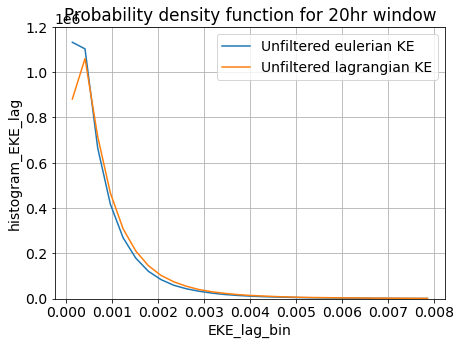

In [183]:
plt.figure(figsize=(7,5))
bins = np.linspace(0, 0.008, 30)


h = histogram(EKE_eul.where(mask_Eul==1), bins=[bins])
h.plot(label='Unfiltered eulerian KE')

plt.ylim(0,1.2*10**6)

h = histogram(EKE_lag_reshaped.EKE_lag, bins=[bins])
h.plot(label='Unfiltered lagrangian KE')
plt.ylim(0,1.2*10**6)
plt.grid()
plt.legend()
plt.title('Probability density function for 20hr window')

fig=plt.gcf()
fig.savefig('eulerian_KE_pdf_20hr.png')

In [63]:
KE_lag_i = xr.Dataset(
    data_vars=dict(
        EKE_lag=(["i", "j"], EKE_lag_reshaped.EKE_lag)
    ),
    coords=dict(
        i=(["i"], EKE_eul.i),
        j=(["j"], EKE_eul.j)
    ))
(EKE_eul_mask.EKE_eul.where(EKE_eul_mask.mask==1)-KE_lag_i.EKE_lag).plot(x='i',levels=np.arange(-0.01,0.01,0.001))

NameError: name 'EKE_lag_reshaped' is not defined

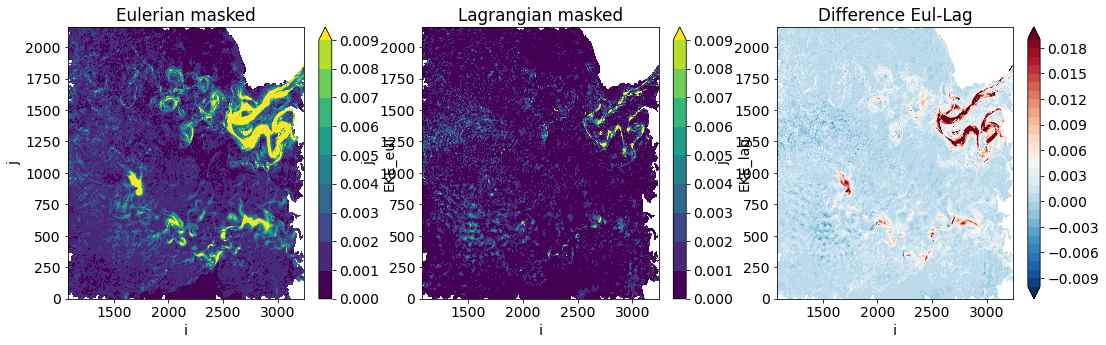

In [210]:
plt.figure(figsize=(18,5))
plt.subplot(131)
EKE_eul_mask.EKE_eul.where(EKE_eul_mask.mask==1).plot(x='i',levels=np.arange(0,0.01,0.001))
plt.title('Eulerian masked')

plt.subplot(132)
KE_lag_i.EKE_lag.plot(x='i',levels=np.arange(0,0.01,0.001))
plt.title('Lagrangian masked')

plt.subplot(133)
(EKE_eul_mask.EKE_eul.where(EKE_eul_mask.mask==1)-KE_lag_i.EKE_lag).plot(x='i',levels=np.arange(-0.01,0.02,0.001))
plt.title('Difference Eul-Lag')

fig=plt.gcf()
fig.savefig('Spatial_KE_14day.png')

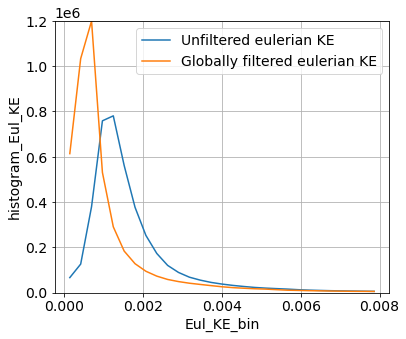

In [82]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(6,5))
bins = np.linspace(0, 0.008, 30)

h = histogram(EKE_eul_mask.EKE_eul.where(EKE_eul_mask.mask==1), bins=[bins])
h.plot(label='Unfiltered eulerian KE')
plt.title('Probability density function')
plt.ylim(0,1.2*10**6)

h = histogram(EKE_eul_filtered.rename('Eul_KE'), bins=[bins])
h.plot(label='Globally filtered eulerian KE')
plt.ylim(0,1.2*10**6)
plt.grid()
plt.legend()
fig=plt.gcf()
fig.savefig('eulerian_KE_pdf.png')

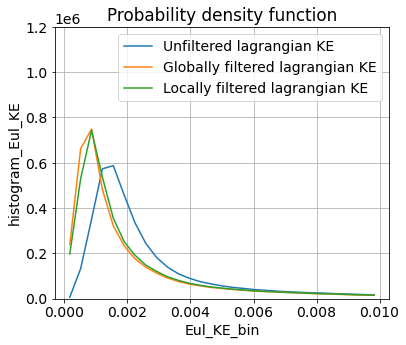

In [264]:
plt.figure(figsize=(6,5))
bins = np.linspace(0, 0.01, 30)

h = histogram(EKE_lag_reshaped.EKE_lag, bins=[bins])
h.plot(label='Unfiltered lagrangian KE')
plt.ylim(0,1.2*10**6)
plt.grid()


h = histogram(EKE_lag_reshaped_filered.EKE_lag.rename('Eul_KE'), bins=[bins])
h.plot(label='Globally filtered lagrangian KE')
plt.ylim(0,1.2*10**6)
plt.grid()



h = histogram(EKE_lag_reshaped_locfilered.EKE_lag.rename('Eul_KE'), bins=[bins])
h.plot(label='Locally filtered lagrangian KE')
plt.title('Global filter lagrangian KE pdf')
plt.ylim(0,1.2*10**6)
plt.grid()
plt.title('Probability density function')
plt.legend()
fig=plt.gcf()
fig.savefig('lagrangian_KE_pdf.png')

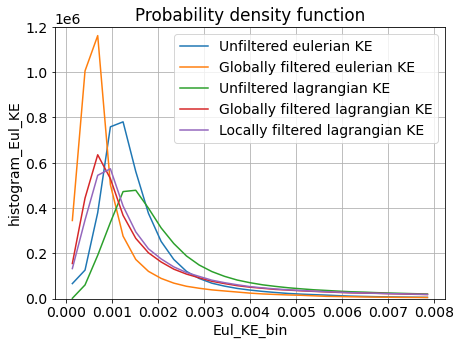

In [265]:
plt.figure(figsize=(7,5))
bins = np.linspace(0, 0.008, 30)


h = histogram(EKE_eul_mask.EKE_eul.where(EKE_eul_mask.mask==1), bins=[bins])
h.plot(label='Unfiltered eulerian KE')
plt.title('Probability density function')
plt.ylim(0,1.2*10**6)

h = histogram(EKE_eul_filtered.rename('Eul_KE').where(EKE_eul_mask.mask==1), bins=[bins])
h.plot(label='Globally filtered eulerian KE')
plt.ylim(0,1.2*10**6)

h = histogram(EKE_lag_reshaped.EKE_lag, bins=[bins])
h.plot(label='Unfiltered lagrangian KE')
plt.ylim(0,1.2*10**6)


h = histogram(EKE_lag_reshaped_filered.EKE_lag.rename('Eul_KE'), bins=[bins])
h.plot(label='Globally filtered lagrangian KE')
plt.ylim(0,1.2*10**6)

h = histogram(EKE_lag_reshaped_locfilered.EKE_lag.rename('Eul_KE'), bins=[bins])
h.plot(label='Locally filtered lagrangian KE')
plt.ylim(0,1.2*10**6)
plt.grid()


plt.title('Probability density function')
plt.legend()

fig=plt.gcf()
fig.savefig('KE_pdf.png')

# Let's find local KE in time and space as a check

In [25]:
KE0 = (grid.interp(uvel_merged.U[168],'X')**2+grid.interp(vvel_merged.V[168],'Y')**2)

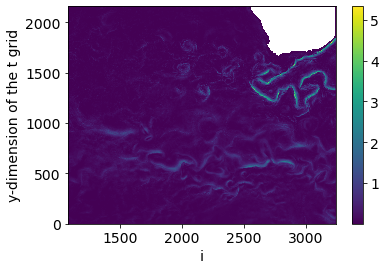

In [26]:
KE0.where(KE0!=0).plot()

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


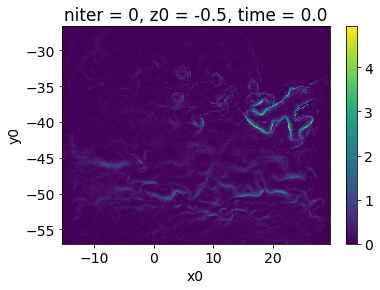

In [39]:
KE0_lag = (ds.u.sel(time=0)**2+ds.v.sel(time=0)**2)
KE0_lag.plot(x='x0')

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


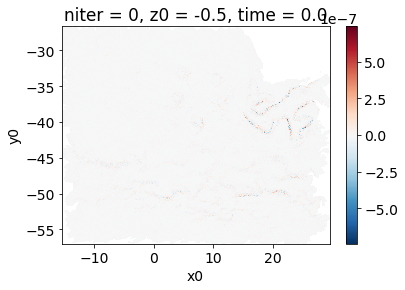

In [46]:
KE_eul = KE0.rename({'i':'x0','j':'y0'})
KE_eul = KE_eul.assign_coords({'x0':KE0_lag.x0,'y0':KE0_lag.y0})
(KE_eul.where(mask>0)-KE0_lag.where(mask>0)).plot()

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


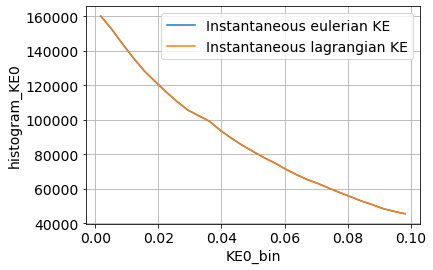

In [48]:
bins = np.linspace(0, 0.1, 30)
h = histogram(KE_eul.where(mask>0).rename('KE0'), bins=[bins])
h.plot(label='Instantaneous eulerian KE')

bins = np.linspace(0, 0.1, 30)
h = histogram(KE0_lag.where(mask>0).rename('KE0'), bins=[bins])
h.plot(label='Instantaneous lagrangian KE')

plt.legend()
plt.grid()

fig=plt.gcf()
fig.savefig('Instantaneous_pdf.png')

In [264]:
((KE0.where(KE0!=0).rename('KE0').where(EKE_eul_mask.mask==1)*area).sum(['i','j'])/np.sum(area)).values

array(0.09985466, dtype=float32)

In [266]:
((KE0_lag.where(KE0_lag!=0)*area).sum(['x','y'])/np.sum(area)).values

array(0.1148271)

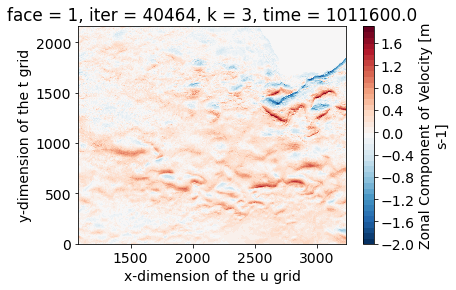

In [298]:
uvel_merged.U[168].plot(levels=np.arange(-2,2,0.1))

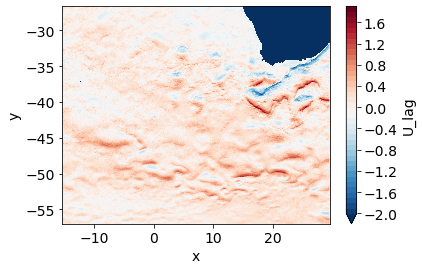

In [299]:
U_lag.U_lag.plot(levels=np.arange(-2,2,0.1),x='x')

In [70]:
(grid.interp(uvel_merged.U[168],'X')-U_lag.U_lag)#.plot(levels=np.arange(-2,2,0.1))

,Array,Chunk
Bytes,174.14 TB,1.36 TB
Shape,"(2160, 2160, 2160, 2160)","(135, 269, 2160, 2160)"
Count,6418 Tasks,256 Chunks
Type,float64,numpy.ndarray


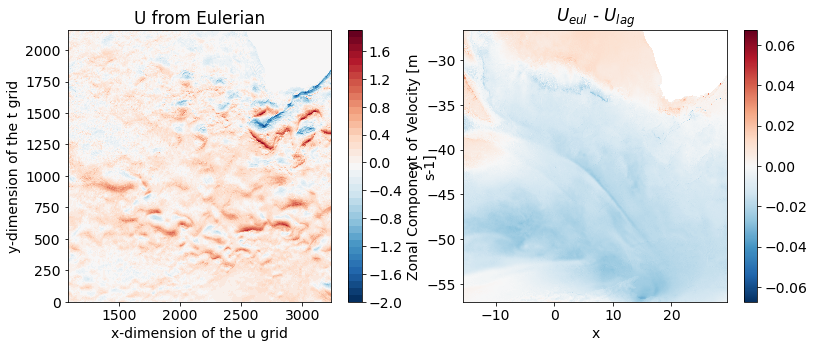

In [402]:
plt.figure(figsize=(13,5))

plt.subplot(121)
uvel_merged.U[168].plot(levels=np.arange(-2,2,0.1))
plt.title('U from Eulerian')

plt.subplot(122)
U_eul = grid.interp(uvel_merged.U[168],'X').rename({'i':'x','j':'y'})
U_eul = U_eul.assign_coords({'x':U_lag.U_lag.x,'y':U_lag.U_lag.y})
(U_eul-U_lag.U_lag.where(U_lag.U_lag>-900)).plot(rasterized=True)
plt.title('$U_{eul}$ - $U_{lag}$')

fig=plt.gcf()
fig.savefig('U_eul - U_lag.png')

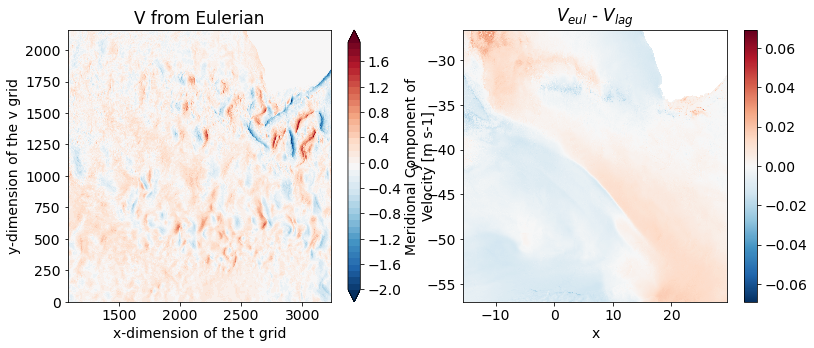

In [411]:
plt.figure(figsize=(13,5))

plt.subplot(121)
vvel_merged.V[168].plot(levels=np.arange(-2,2,0.1))
plt.title('V from Eulerian')

plt.subplot(122)
V_eul = grid.interp(vvel_merged.V[168],'Y').rename({'i':'x','j':'y'})
V_eul = V_eul.assign_coords({'x':V_lag.V_lag.x,'y':V_lag.V_lag.y})
(V_eul-V_lag.V_lag.where(V_lag.V_lag>-900)).plot(rasterized=True)
plt.title('$V_{eul}$ - $V_{lag}$')

fig=plt.gcf()
fig.savefig('V_eul - V_lag.png')

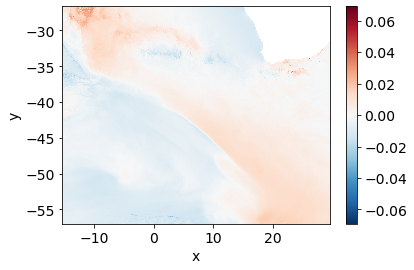

In [358]:
V_eul = grid.interp(vvel_merged.V[168],'Y').rename({'i':'x','j':'y'})
V_eul = V_eul.assign_coords({'x':V_lag.V_lag.x,'y':U_lag.U_lag.y})
(V_eul-V_lag.V_lag.where(V_lag.V_lag>-900)).plot()

In [214]:
dx = np.cumsum(np.fromfile('/home/spencerj/agulhas-offline/input_agulhas/delx_llc_4320_agulhas.bin','>f4'))

In [213]:
dy = np.cumsum(np.fromfile('/home/spencerj/agulhas-offline/input_agulhas/dely_llc_4320_agulhas.bin','>f4'))

In [54]:
KE_time = ((ds.u.drop('niter')**2+ds.v.drop('niter')**2)*0.5).where(mask>0).sum(['x0','y0'])
KE_time_eul =((grid.interp(uvel_merged.U,'X')**2+grid.interp(vvel_merged.V,'Y')**2)*0.5).where(mask_Eul>0).sum(['i','j'])
KE_time_eul['time']=KE_time_eul.time-KE_time_eul.time[168]#=KE_time_eul.assign_coords({'time':KE_time.time})

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/utils.py:29: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


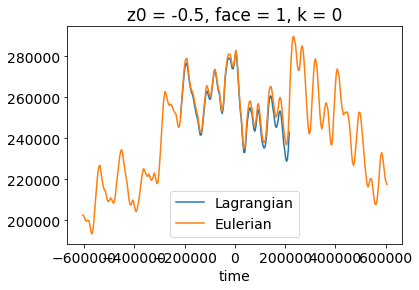

In [57]:
dt=60
KE_time.isel(time=slice(168-dt,169+dt)).plot(label='Lagrangian')
KE_time_eul.plot(label='Eulerian')
plt.legend()

fig=plt.gcf()
fig.savefig('instantaneous_KE_time.png')

In [51]:
KE_time.time

<xarray.DataArray 'time' (time: 337)>
array([-604800., -601200., -597600., ...,  597600.,  601200.,  604800.])
Coordinates:
    z0       float64 -0.5
  * time     (time) float64 -6.048e+05 -6.012e+05 ... 6.012e+05 6.048e+05

In [53]:
KE_time_eul.time-KE_time_eul.time[168]

<xarray.DataArray 'time' (time: 337)>
array([-604800., -601200., -597600., -594000., -590400., -586800.,
       -583200., -579600., -576000., -572400., -568800., -565200.,
       -561600., -558000., -554400., -550800., -547200., -543600.,
       -540000., -536400., -532800., -529200., -525600., -522000.,
       -518400., -514800., -511200., -507600., -504000., -500400.,
       -496800., -493200., -489600., -486000., -482400., -478800.,
       -475200., -471600., -468000., -464400., -460800., -457200.,
       -453600., -450000., -446400., -442800., -439200., -435600.,
       -432000., -428400., -424800., -421200., -417600., -414000.,
       -410400., -406800., -403200., -399600., -396000., -392400.,
       -388800., -385200., -381600., -378000., -374400., -370800.,
       -367200., -363600., -360000., -356400., -352800., -349200.,
       -345600., -342000., -338400., -334800., -331200., -327600.,
       -324000., -320400., -316800., -313200., -309600., -306000.,
       -302400., -298800., -295200., -291600., -288000., -284400.,
       -280800., -277200., -273600., -270000., -266400., -262800.,
       -259200., -255600., -252000., -248400., -244800., -241200.,
       -237600., -234000., -230400., -226800., -223200., -219600.,
       -216000., -212400., -208800., -205200., -201600., -198000.,
       -194400., -190800., -187200., -183600., -180000., -176400.,
...
        194400.,  198000.,  201600.,  205200.,  208800.,  212400.,
        216000.,  219600.,  223200.,  226800.,  230400.,  234000.,
        237600.,  241200.,  244800.,  248400.,  252000.,  255600.,
        259200.,  262800.,  266400.,  270000.,  273600.,  277200.,
        280800.,  284400.,  288000.,  291600.,  295200.,  298800.,
        302400.,  306000.,  309600.,  313200.,  316800.,  320400.,
        324000.,  327600.,  331200.,  334800.,  338400.,  342000.,
        345600.,  349200.,  352800.,  356400.,  360000.,  363600.,
        367200.,  370800.,  374400.,  378000.,  381600.,  385200.,
        388800.,  392400.,  396000.,  399600.,  403200.,  406800.,
        410400.,  414000.,  417600.,  421200.,  424800.,  428400.,
        432000.,  435600.,  439200.,  442800.,  446400.,  450000.,
        453600.,  457200.,  460800.,  464400.,  468000.,  471600.,
        475200.,  478800.,  482400.,  486000.,  489600.,  493200.,
        496800.,  500400.,  504000.,  507600.,  511200.,  514800.,
        518400.,  522000.,  525600.,  529200.,  532800.,  536400.,
        540000.,  543600.,  547200.,  550800.,  554400.,  558000.,
        561600.,  565200.,  568800.,  572400.,  576000.,  579600.,
        583200.,  586800.,  590400.,  594000.,  597600.,  601200.,
        604800.])
Coordinates:
  * time     (time) float64 4.068e+05 4.104e+05 4.14e+05 ... 1.613e+06 1.616e+06
    z0       float64 -0.5
    face     int64 1
    k        int64 0

In [69]:
KE_time_eul.isel(time=-1).values

array(233039.84, dtype=float32)

In [71]:
inst_EKE = ((ds.u.drop('niter')**2+ds.v.drop('niter')**2)*0.5).sel(time=0)#.plot()
x_pd = ds.x.sel(time=0).to_dataframe()
y_pd = ds.y.sel(time=0).to_dataframe()
merged_pd = x_pd.drop(columns=["niter","time"]).join(y_pd).drop(columns=["niter","time"])
import pandas as pd
index = pd.MultiIndex.from_frame(merged_pd)
inst_df = pd.DataFrame(inst_EKE.values, index=index)

In [73]:
inst_KE = inst_df.rename(columns={0: "KE_lag"}).to_xarray()

In [76]:
inst_EKE = ((ds.u.drop('niter')**2+ds.v.drop('niter')**2)*0.5).sel(time=0)
mask_Eul = inst_KE.where(np.isnan(inst_KE),1)
mask_Eul = mask_Eul.where(mask_Eul==1,0)
mask_Eul

<xarray.Dataset>
Dimensions:  (x: 2160, y: 2160)
Coordinates:
  * x        (x) float64 -15.49 -15.47 -15.45 -15.43 ... 29.43 29.45 29.47 29.49
  * y        (y) float64 -57.0 -56.99 -56.98 -56.97 ... -26.69 -26.68 -26.66
Data variables:
    KE_lag   (x, y) float64 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0

In [79]:
Eul_mask = mask_Eul.KE_lag.rename({'x':'i','y':'j'})
Eul_mask = Eul_mask.assign_coords({'i':vvel_merged.V.i,'j':uvel_merged.U.j})

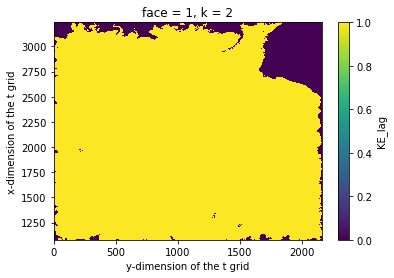

In [80]:
Eul_mask.plot()